### 개인소득예측(분류)
- income - 50K 초과는 1, 50K 이하는 0

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")
train.shape, test.shape

((189697, 42), (59762, 41))

In [10]:
y = train.loc[:,'income']
train = train.drop(columns='income')
print(len(train),len(y))

189697 189697


In [11]:
#전처리를 위해 train데이터와 test데이터를 합침
data = pd.concat([train,test],ignore_index=True)

In [27]:
data.columns

Index(['ID', 'age', 'class of worker', 'detailed industry recode',
       'detailed occupation recode', 'education', 'wage per hour',
       'enroll in edu inst last wk', 'marital stat', 'major industry code',
       'major occupation code', 'race', 'hispanic origin', 'sex',
       'member of a labor union', 'reason for unemployment',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer stat',
       'region of previous residence', 'state of previous residence',
       'detailed household and family stat',
       'detailed household summary in household',
       'migration code-change in msa', 'migration code-change in reg',
       'migration code-move within reg', 'live in this house 1 year ago',
       'migration prev res in sunbelt', 'num persons worked for employer',
       'family members under 18', 'country of birth father',
       'country of birth mother', 'country of birth self', 'citizenship',
       'own bu

In [36]:
for i in range(len(data.columns)) :
    print('[',data.columns[i],']')
    print(data.iloc[:,i].value_counts())
    print("="*80)

[ ID ]
2047      2
56923     2
46806     2
48855     2
50904     2
52953     2
55002     2
57051     2
59100     2
1856      2
3905      2
5954      2
8003      2
10052     2
12101     2
14150     2
16199     2
18248     2
20297     2
22346     2
24395     2
44757     2
42708     2
40659     2
18120     2
1728      2
3777      2
5826      2
7875      2
9924      2
         ..
131455    1
129408    1
127361    1
125314    1
123267    1
121220    1
119173    1
117126    1
115079    1
113032    1
110985    1
108938    1
106891    1
104844    1
102797    1
100750    1
98703     1
96656     1
94609     1
92562     1
90515     1
88468     1
86421     1
84374     1
82327     1
80280     1
78233     1
76186     1
74139     1
131072    1
Name: ID, Length: 189697, dtype: int64
[ age ]
34.0    4229
35.0    4196
33.0    4117
36.0    4070
38.0    4052
37.0    4042
4.0     4018
31.0    4014
5.0     3957
3.0     3949
30.0    3930
32.0    3920
39.0    3891
40.0    3890
7.0     3869
2.0     3845
8.0   

Name: major occupation code, dtype: int64
[ race ]
 White                          209270
 Black                           25367
 Asian or Pacific Islander        7274
 Other                            4552
 Amer Indian Aleut or Eskimo      2820
Name: race, dtype: int64
[ hispanic origin ]
 All other                    215136
 Mexican-American               9985
 Mexican (Mexicano)             9006
 Central or South American      4853
 Puerto Rican                   4097
 Other Spanish                  3106
 Cuban                          1447
 NA                             1055
 Chicano                         392
 Do not know                     382
Name: hispanic origin, dtype: int64
[ sex ]
 Female    126085
 Male      117481
?             822
Name: sex, dtype: int64
[ member of a labor union ]
 Not in universe    225458
 No                  20228
 Yes                  3773
Name: member of a labor union, dtype: int64
[ reason for unemployment ]
 Not in universe          241400
 Ot

Name: state of previous residence, dtype: int64
[ detailed household and family stat ]
 Householder                                        67269
 Child <18 never marr not in subfamily              61769
 Spouse of householder                              51643
 Nonfamily householder                              27835
 Child 18+ never marr Not in a subfamily            14917
 Secondary individual                                7647
 Other Rel 18+ ever marr not in subfamily            2485
 Grandchild <18 never marr child of subfamily RP     2292
 Other Rel 18+ never marr not in subfamily           2110
 Grandchild <18 never marr not in subfamily          1300
 Child 18+ ever marr Not in a subfamily              1224
 Child under 18 of RP of unrel subfamily              907
 Child 18+ ever marr RP of subfamily                  840
 RP of unrelated subfamily                            839
 Other Rel 18+ spouse of subfamily RP                 801
 Other Rel <18 never marr child of subfamil

Name: country of birth mother, dtype: int64
[ country of birth self ]
 United-States                   221279
 Mexico                            7133
 ?                                 4287
 Puerto-Rico                       1736
 Philippines                       1090
 Germany                           1068
 Cuba                              1060
 Canada                             899
 El-Salvador                        872
 Dominican-Republic                 846
 China                              596
 South Korea                        590
 England                            560
 Columbia                           545
 Italy                              520
 India                              511
 Poland                             472
 Vietnam                            470
 Japan                              435
 Guatemala                          423
 Jamaica                            408
 Ecuador                            331
 Peru                               319
 Nicaragua

# 전처리

### 1. detailed occupation recode가 0일 때 class of worker를 not in universe로 채워줌

In [7]:
for i in tqdm_notebook(range(len(data))) :
    if pd.isnull(data["class of worker"][i]) == True and data['detailed occupation recode'][i] ==0 :
        data['class of worker'][i] = ' Not in universe'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 2. detailed occupation recode 별로 detailed industry recode 빈도가 높은것을 뽑음 -> detailed industry recode를 채워줌

In [8]:
li = []
for i in range(len(data['detailed occupation recode'].unique())) :
    li.append(data['detailed industry recode'][data['detailed occupation recode'] == i].value_counts().index[0])
     
qt =data['detailed occupation recode'][data['detailed industry recode'].isna()].values
idx = data[data["detailed industry recode"].isnull()].index

for i in range(len(qt)):    
    data.loc[idx[i],"detailed industry recode"] = li[qt[i]]

### 3. detailed occupation recocde 별로 class of worker 빈도가 높은 것을 뽑음 -> class of worker를 채워줌

In [9]:
li_2 = []
for i in range(len(data['detailed industry recode'].unique())) :
    li_2.append(data['class of worker'][data['detailed industry recode'] == i].value_counts().index[0])
    
qt_2 =data['detailed industry recode'][data['class of worker'].isna()].values
idx_2 = data[data["class of worker"].isnull()].index

for i in range(len(qt_2)):    
    data.loc[idx_2[i],"class of worker"] = li_2[int(qt_2[i])]

### 4

In [10]:
# train_tmp = pd.concat([train,y],axis =1)

### 5.education의 널값에 high school graduate를 넣음

In [11]:
data['education'][data['education'].isna()]=' High school graduate'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 6. education 별 age 중위값을 구해서 결측치를 채워준다

In [13]:
for idx in tqdm_notebook(data[data["age"].isnull()].index) :
    data.loc[idx,'age'] = data.loc[data['education']==data.loc[idx,'education'],'age'].median()

### 7. enroll in edu inst last wk 4등급으로 나눠서 채워줌

In [14]:
educol = data['education'].unique()
x = 0
for i in educol :
    print(x,i)
    x+=1

0  Bachelors degree(BA AB BS)
1  High school graduate
2  Children
3  Some college but no degree
4  Masters degree(MA MS MEng MEd MSW MBA)
5  10th grade
6  11th grade
7  Associates degree-academic program
8  7th and 8th grade
9  Associates degree-occup /vocational
10  5th or 6th grade
11  1st 2nd 3rd or 4th grade
12  Less than 1st grade
13  Doctorate degree(PhD EdD)
14  12th grade no diploma
15  9th grade
16  Prof school degree (MD DDS DVM LLB JD)


In [15]:
data['enroll in edu inst last wk'][data['education'] == educol[5]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[6]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[8]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[10]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[11]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[12]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[14]] = 'C'
data['enroll in edu inst last wk'][data['education'] == educol[15]] = 'C'

data['enroll in edu inst last wk'][data['education'] == educol[1]] = 'B'
data['enroll in edu inst last wk'][data['education'] == educol[3]] = 'B'
data['enroll in edu inst last wk'][data['education'] == educol[7]] = 'B'
data['enroll in edu inst last wk'][data['education'] == educol[9]] = 'B'

data['enroll in edu inst last wk'][data['education'] == educol[0]] = 'A'
data['enroll in edu inst last wk'][data['education'] == educol[4]] = 'A'
data['enroll in edu inst last wk'][data['education'] == educol[13]] = 'A'
data['enroll in edu inst last wk'][data['education'] == educol[16]] = 'A'

data['enroll in edu inst last wk'][data['education'] == educol[2]] = 'D'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dhrtj\Anac

### 8. major occupation code 속성 별 최빈값을 major industry code의 결측치에 넣어줌

In [16]:
moc_col = data['major occupation code'].value_counts().index
for i in range(len(moc_col)) :
    print(i,moc_col[i])

0  Not in universe
1  Adm support including clerical
2  Professional specialty
3  Executive admin and managerial
4  Other service
5  Sales
6  Precision production craft & repair
7  Machine operators assmblrs & inspctrs
8  Handlers equip cleaners etc 
9  Transportation and material moving
10  Farming forestry and fishing
11  Technicians and related support
12  Protective services
13  Private household services
14  Armed Forces


In [17]:
for i in range(len(moc_col)):
    data.loc[data['major industry code'][data['major industry code'].isna()][data['major occupation code'] == moc_col[i]].index,'major industry code'] = data['major industry code'][data['major occupation code'] == moc_col[i]].mode()[0] 

### 9. major industry code 속성 별 최빈값을 major occupation code의 결측치에 넣어줌

In [18]:
mic_col = data['major industry code'].value_counts().index
for i in range(len(mic_col)) :
    print(i,mic_col[i])

0  Not in universe or children
1  Retail trade
2  Manufacturing-durable goods
3  Education
4  Manufacturing-nondurable goods
5  Finance insurance and real estate
6  Construction
7  Business and repair services
8  Medical except hospital
9  Public administration
10  Other professional services
11  Transportation
12  Hospital services
13  Wholesale trade
14  Agriculture
15  Personal services except private HH
16  Social services
17  Entertainment
18  Communications
19  Utilities and sanitary services
20  Private household services
21  Mining
22  Forestry and fisheries
23  Armed Forces


In [19]:
for i in range(len(mic_col)) :
    data.loc[data['major occupation code'][data['major occupation code'].isna()][data['major industry code'] == mic_col[i]].index,'major occupation code'] = data['major occupation code'][data['major industry code'] == mic_col[i]].mode()[0]

### 10. reason for unemployment 는 결측치에 not in universe로 채워줌

In [20]:
data['reason for unemployment'][data['reason for unemployment'].isna()]=' Not in universe'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 11_1. full or part time employment stat 결측치에 Children or Armed Forces 넣음

In [21]:
data['full or part time employment stat'][data['full or part time employment stat'] == '0'] = ' Children or Armed Forces'
data['full or part time employment stat'][data['full or part time employment stat'].isna()]=' Children or Armed Forces'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 11_2. full or part time employment stat 의 children or armed forces를 19세 기준으로 나눔

In [22]:
data.loc[data['age'][data['age'] >= 19][data['full or part time employment stat'] == ' Children or Armed Forces'].index,'full or part time employment stat'] = 'ArmedForces'

### 12. capital gain의 결측치에 0 넣기

In [23]:
data['capital gains'][data['capital gains'].isna()] = 0

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 13. dividends from stocks의 결측치에 0 넣기

In [24]:
data['dividends from stocks'][data['dividends from stocks'].isna()] = 0

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 14. tax filer stat의 결측치에 single 넣기

In [25]:
data['tax filer stat'][data['tax filer stat'].isna()] = ' Single'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 15.  state of previous residence 값이 '?' 인 것을 not in universe로 채워준다.

In [26]:
data['state of previous residence'][data['state of previous residence']== ' ?']= ' Not in universe'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 16. detailed household and family stat에서 결측치를 Spouse of householder로 채워준다

In [27]:
data['detailed household and family stat'][data['detailed household and family stat'].isna()] = ' Spouse of householder'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [28]:
#컬럼 별 결측치 확인
data.isna().sum()

ID                                               0
age                                              0
class of worker                                  0
detailed industry recode                         0
detailed occupation recode                       0
education                                        0
wage per hour                                    0
enroll in edu inst last wk                       0
marital stat                                     0
major industry code                              0
major occupation code                            0
race                                           176
hispanic origin                                  0
sex                                           5071
member of a labor union                          0
reason for unemployment                          0
full or part time employment stat                0
capital gains                                    0
capital losses                                   0
dividends from stocks          

In [32]:
#컬럼 별 value_counts
co = data.columns
for i in co :
    print("=========================",i,"==============================\n",data[i].value_counts())

========================= ID ==============================
 2047      2
56923     2
46806     2
48855     2
50904     2
52953     2
55002     2
57051     2
59100     2
1856      2
3905      2
5954      2
8003      2
10052     2
12101     2
14150     2
16199     2
18248     2
20297     2
22346     2
24395     2
44757     2
42708     2
40659     2
18120     2
1728      2
3777      2
5826      2
7875      2
9924      2
         ..
131455    1
129408    1
127361    1
125314    1
123267    1
121220    1
119173    1
117126    1
115079    1
113032    1
110985    1
108938    1
106891    1
104844    1
102797    1
100750    1
98703     1
96656     1
94609     1
92562     1
90515     1
88468     1
86421     1
84374     1
82327     1
80280     1
78233     1
76186     1
74139     1
131072    1
Name: ID, Length: 189697, dtype: int64
========================= age ==============================
 7.0     5409
42.0    5210
37.0    4961
39.0    4871
32.0    4250
34.0    4229
35.0    4196
33.0    4117
36

In [36]:
#race의 널값에 White를 넣어줬다
data['race'][data['race'].isna()]=' White'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [37]:
#sex의 널값에 Female을 채웠다
data['sex'][data['sex'].isna()]=' Female'
#sex의 값이 ? 인 것에 Female을 채웠다
data['sex'][data['sex']=='?'] = ' Female'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [44]:
#weeks worked in year의 널값에 0을 넣음
data['weeks worked in year'][data['weeks worked in year'].isna()] = 0

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
#year 값 변환 / ?에 95 넣기 / 널값에 95넣기
data['year'][data['year']==95] ='95'
data['year'][data['year']==94] ='94'
data['year'][data['year']=='?'] ='95'
data['year'][data['year'].isna()] = '95'

C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\dhrtj\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\dhrtj\Anaconda3\lib\

In [47]:
#ID컬럼 삭제
data = data.drop(columns='ID')

In [49]:
data

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,family members under 18,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year
0,47.0,Federal government,31.0,4,Bachelors degree(BA AB BS),0,A,Married-civilian spouse present,Utilities and sanitary services,Professional specialty,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,2,Not in universe,2,52.0,95
1,26.0,Private,36.0,27,High school graduate,425,B,Never married,Private household services,Private household services,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,16.0,95
2,48.0,Self-employed-not incorporated,33.0,16,High school graduate,0,B,Married-civilian spouse present,Retail trade,Sales,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,50.0,95
3,8.0,Not in universe,0.0,0,Children,0,D,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,95
4,51.0,Private,8.0,26,Some college but no degree,0,B,Married-civilian spouse present,Manufacturing-durable goods,Adm support including clerical,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52.0,95
5,6.0,Not in universe,0.0,0,Children,0,D,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,95
6,6.0,Not in universe,0.0,0,Children,0,D,Never married,Not in universe or children,Not in universe,...,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,95
7,50.0,Private,16.0,4,Masters degree(MA MS MEng MEd MSW MBA),0,A,Married-civilian spouse present,Manufacturing-durable goods,Professional specialty,...,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,No,1,52.0,95
8,70.0,Not in universe,0.0,0,High school graduate,0,B,Married-civilian spouse present,Not in universe or children,Not in universe,...,Not in universe,Germany,Germany,United-States,Native- Born in the United States,0,No,1,0.0,94
9,9.0,Not in universe,0.0,0,Children,0,D,Never married,Not in universe or children,Not in universe,...,Father only present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,95


In [50]:
#one hot encoding
tlsdntjr = data[["age","detailed industry recode",'detailed occupation recode','wage per hour','capital gains','capital losses','dividends from stocks','num persons worked for employer','own business or self employed','veterans benefits','weeks worked in year']]

In [51]:
shinuseok =data.drop(columns=shinuseok.columns)
shinuseok_dummy = pd.get_dummies(shinuseok)

In [52]:
res = pd.concat([tlsdntjr,shinuseok_dummy],axis = 1)
res

,age,detailed industry recode,detailed occupation recode,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,own business or self employed,veterans benefits,...,citizenship_ Foreign born- Not a citizen of U S,citizenship_ Foreign born- U S citizen by naturalization,citizenship_ Native- Born abroad of American Parent(s),citizenship_ Native- Born in Puerto Rico or U S Outlying,citizenship_ Native- Born in the United States,fill inc questionnaire for veteran's admin_ No,fill inc questionnaire for veteran's admin_ Not in universe,fill inc questionnaire for veteran's admin_ Yes,year_94,year_95
0,47.0,31.0,4,0,0.0,0,200.0,6,2,2,...,0,0,0,0,1,0,1,0,0,1
1,26.0,36.0,27,425,0.0,0,0.0,1,0,2,...,0,0,0,0,1,0,1,0,0,1
2,48.0,33.0,16,0,0.0,0,0.0,1,0,2,...,0,0,0,0,1,0,1,0,0,1
3,8.0,0.0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
4,51.0,8.0,26,0,0.0,0,0.0,6,0,2,...,0,0,0,0,1,0,1,0,0,1
5,6.0,0.0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
6,6.0,0.0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
7,50.0,16.0,4,0,0.0,0,2000.0,6,0,1,...,0,0,0,0,1,1,0,0,0,1
8,70.0,0.0,0,0,0.0,0,0.0,0,0,1,...,0,0,0,0,1,1,0,0,1,0
9,9.0,0.0,0,0,0.0,0,0.0,0,0,0,...,0,0,0,0,1,0,1,0,0,1


In [53]:
#train, test 다시 분리
train = res.iloc[:189697,:]
train = pd.concat([train,y],axis = 1)
test = res.iloc[189697:,:]

In [54]:
X_test = test
y_train = train.iloc[:,-1]
X_train = train.drop(columns='income')

In [55]:
name_1 = []
for i in range(len(X_train.columns)):
    if '<' in X_train.columns[i] :
           name_1.append(X_train.columns[i])
name_1

['detailed household and family stat_ Child <18 ever marr RP of subfamily',
 'detailed household and family stat_ Child <18 ever marr not in subfamily',
 'detailed household and family stat_ Child <18 never marr RP of subfamily',
 'detailed household and family stat_ Child <18 never marr not in subfamily',
 'detailed household and family stat_ Child <18 spouse of subfamily RP',
 'detailed household and family stat_ Grandchild <18 ever marr not in subfamily',
 'detailed household and family stat_ Grandchild <18 never marr RP of subfamily',
 'detailed household and family stat_ Grandchild <18 never marr child of subfamily RP',
 'detailed household and family stat_ Grandchild <18 never marr not in subfamily',
 'detailed household and family stat_ Other Rel <18 ever marr RP of subfamily',
 'detailed household and family stat_ Other Rel <18 ever marr not in subfamily',
 'detailed household and family stat_ Other Rel <18 never marr child of subfamily RP',
 'detailed household and family stat

In [56]:
# 컬럼 명에 '<' 기호가 있어 모델을 돌릴 수 없음 -> 컬럼명을 바꾸어 줌
X_train.rename(columns={name_1[0]:'18_0'},inplace=True)
X_train.rename(columns={name_1[1]:'18_1'},inplace=True)
X_train.rename(columns={name_1[2]:'18_2'},inplace=True)
X_train.rename(columns={name_1[3]:'18_3'},inplace=True)
X_train.rename(columns={name_1[4]:'18_4'},inplace=True)
X_train.rename(columns={name_1[5]:'18_5'},inplace=True)
X_train.rename(columns={name_1[6]:'18_6'},inplace=True)
X_train.rename(columns={name_1[7]:'18_7'},inplace=True)
X_train.rename(columns={name_1[8]:'18_8'},inplace=True)
X_train.rename(columns={name_1[9]:'18_9'},inplace=True)
X_train.rename(columns={name_1[10]:'18_10'},inplace=True)
X_train.rename(columns={name_1[11]:'18_11'},inplace=True)
X_train.rename(columns={name_1[12]:'18_12'},inplace=True)
X_train.rename(columns={name_1[13]:'18_13'},inplace=True)
X_train.rename(columns={name_1[14]:'18_14'},inplace=True)


In [57]:
X_test.rename(columns={name_1[0]:'18_0'},inplace=True)
X_test.rename(columns={name_1[1]:'18_1'},inplace=True)
X_test.rename(columns={name_1[2]:'18_2'},inplace=True)
X_test.rename(columns={name_1[3]:'18_3'},inplace=True)
X_test.rename(columns={name_1[4]:'18_4'},inplace=True)
X_test.rename(columns={name_1[5]:'18_5'},inplace=True)
X_test.rename(columns={name_1[6]:'18_6'},inplace=True)
X_test.rename(columns={name_1[7]:'18_7'},inplace=True)
X_test.rename(columns={name_1[8]:'18_8'},inplace=True)
X_test.rename(columns={name_1[9]:'18_9'},inplace=True)
X_test.rename(columns={name_1[10]:'18_10'},inplace=True)
X_test.rename(columns={name_1[11]:'18_11'},inplace=True)
X_test.rename(columns={name_1[12]:'18_12'},inplace=True)
X_test.rename(columns={name_1[13]:'18_13'},inplace=True)
X_test.rename(columns={name_1[14]:'18_14'},inplace=True)

C:\Users\dhrtj\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


# model

### catboost

In [58]:
model = CatBoostClassifier().fit(X_train,y_train)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.073929
0:	learn: 0.5516395	total: 296ms	remaining: 4m 55s
1:	learn: 0.4631669	total: 562ms	remaining: 4m 40s
2:	learn: 0.3834295	total: 887ms	remaining: 4m 54s
3:	learn: 0.3338638	total: 1.31s	remaining: 5m 27s
4:	learn: 0.3004093	total: 1.87s	remaining: 6m 12s
5:	learn: 0.2665820	total: 2.16s	remaining: 5m 58s
6:	learn: 0.2418558	total: 2.48s	remaining: 5m 51s
7:	learn: 0.2148194	total: 2.84s	remaining: 5m 52s
8:	learn: 0.1984572	total: 3.11s	remaining: 5m 42s
9:	learn: 0.1872252	total: 3.4s	remaining: 5m 36s
10:	learn: 0.1758832	total: 3.69s	remaining: 5m 32s
11:	learn: 0.1712278	total: 3.98s	remaining: 5m 27s
12:	learn: 0.1660177	total: 4.2s	remaining: 5m 19s
13:	learn: 0.1609633	total: 4.42s	remaining: 5m 11s
14:	learn: 0.1560415	total: 4.65s	remaining: 5m 5s
15:	learn: 0.1510940	total: 4.94s	remaining: 5m 4s
16:	learn: 0.1474219	total: 5.19s	remaining: 5m
17:	learn: 0.1439354	total: 5.5s	remaining: 4m 59s
18:	learn: 0.1418105	total: 5.77s	remaining: 4m 57s
1

In [59]:
model.score(X_train,y_train)

0.9639372262081108

In [60]:
pred = model.predict(X_test)
pred

array([0., 0., 0., ..., 0., 0., 0.])

In [63]:
cat_prob = pd.DataFrame(model.predict_proba(X_test))

In [65]:
# income을 1로 예측할 확률이 0.34이상이면 1로 예측
cat_li = []
for i in range(len(cat_prob)) :
    if cat_prob.iloc[i,1] >=0.34 :
        cat_li.append(1)
    else :
        cat_li.append(0)
np.sum(cat_li)

4894

In [66]:
# pd.DataFrame(cat_li).to_csv("last_sub.csv")

https://www.kaggle.com/c/jc1c2/leaderboard
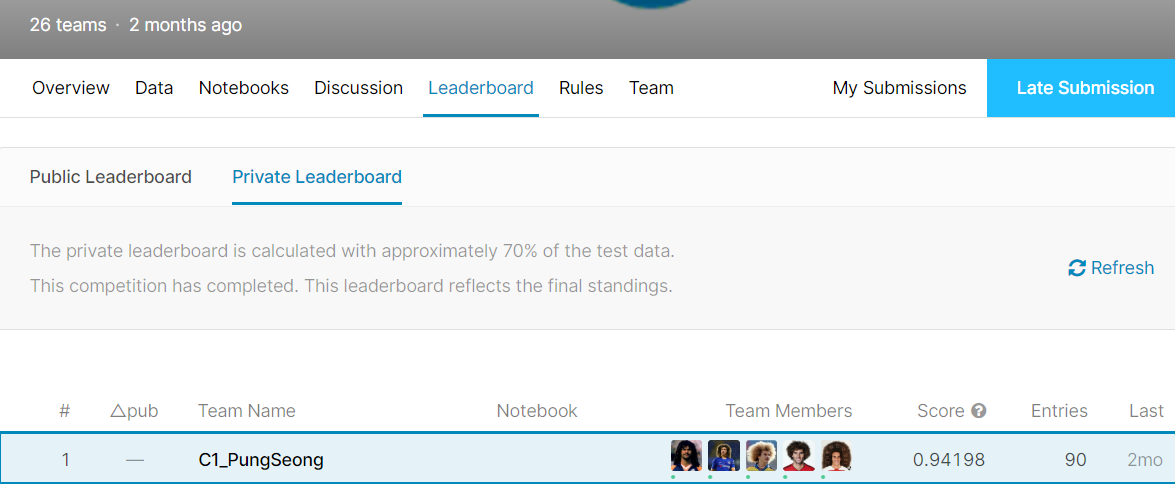